# Computer Vision - HW04 - 98722278
Index:

1. Canny Edge Detector
    1. Gaussian Noise
    2. Gradient Intensification
    3. Non-Max Suppression
    4. Thresholding
2. Straight Line Detector
    1.
    2.

## 1 Implementation of Canny Edge Detector
1. Gaussian Noise
2. Gradient Intensification
3. Non-Max Suppression
4. Thresholding

In [2]:
import cv2
import numpy as np
from scipy import ndimage
from PIL import Image

import matplotlib.pyplot as plt

import time
%matplotlib inline

In [3]:
def open_image(path):
    """
    Open an image using PIL library

    :param path: path to image file-like
    :return: PIL image object
    """
    image = Image.open(path)
    return image


In [4]:
def show_image(image, cmap='gray'):
    """
    Show PIL image or numpy image in default viewer of OS

    :param image: image data
    :param cmap: color map of input numpy array
    :return: None
    """
    if str(type(image)).__contains__('PIL'):
        image.show()
    elif str(type(image)).__contains__('numpy'):
        if cmap=='gray':
            Image.fromarray(np.uint8(image), mode='L').show()
        elif cmap == 'bw':
            size = image.shape[::-1]
            data_bytes = np.packbits(image, axis=1)
            Image.frombytes(mode='1', size=size, data=data_bytes).show()
        else:
            raise ValueError('color map is invalid.')
    else:
        raise ValueError('Input t is not valid.')

In [5]:
class ToGrayscale:
    """
    Get and PIL image or numpy n-dim array as image and convert it to grayscale image
    """

    def __init__(self):
        pass

    def __call__(self, image):
        """
        Get and PIL image or numpy n-dim array as image and convert it to grayscale image

        :param image: input image data
        :return: Grayscale image of input type
        """
        if str(type(image)).__contains__('PIL'):
            image = image.convert('L')
        elif str(type(image)).__contains__('numpy'):
            image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])
        else:
            raise ValueError('Input type is not valid.')
        return image

### 1.A Gaussian Noise

In [8]:
class GaussianNoise:
    def __init__(self, size=5, std=1):
        self.size = size
        self.std = std

    def _gaussian(self, r2):
        """
        Sample one instance from gaussian distribution regarding
        given squared-distance:r2, standard-deviation:std and general-constant:k

        :param r: squared distance from center of gaussian distribution
        :param std: standard deviation

        :return: A sampled number obtained from gaussian
        """
        return np.exp(-r2/(2.*self.std**2)) / (2.*np.pi*self.std**2)

    def _gaussian_kernel(self):
        """
        Creates a gaussian kernel regarding given size and std.
        Note that to define interval with respect to the size,
        I used linear space sampling which may has
        lower accuracy from renowned libraries.

        :param std: standard deviation value
        :param size: size of the output kernel
        :return: A gaussian kernel with size of (size*size)
        """
        self.size = int(self.size) // 2
        x, y = np.mgrid[-self.size:self.size+1, -self.size:self.size+1]
        distance = x**2+ y**2
        kernel = self._gaussian(r2=distance)
        return kernel

    def __call__(self, image):
        """
        Applies gaussian noise on the given image

        :param image: Input image in grayscale mode numpy ndarray or cv2 image
        :param size: Size of the gaussian kernel
        :param std: Standard deviation value for gaussian kernel
        """

        return ndimage.convolve(image, self._gaussian_kernel())


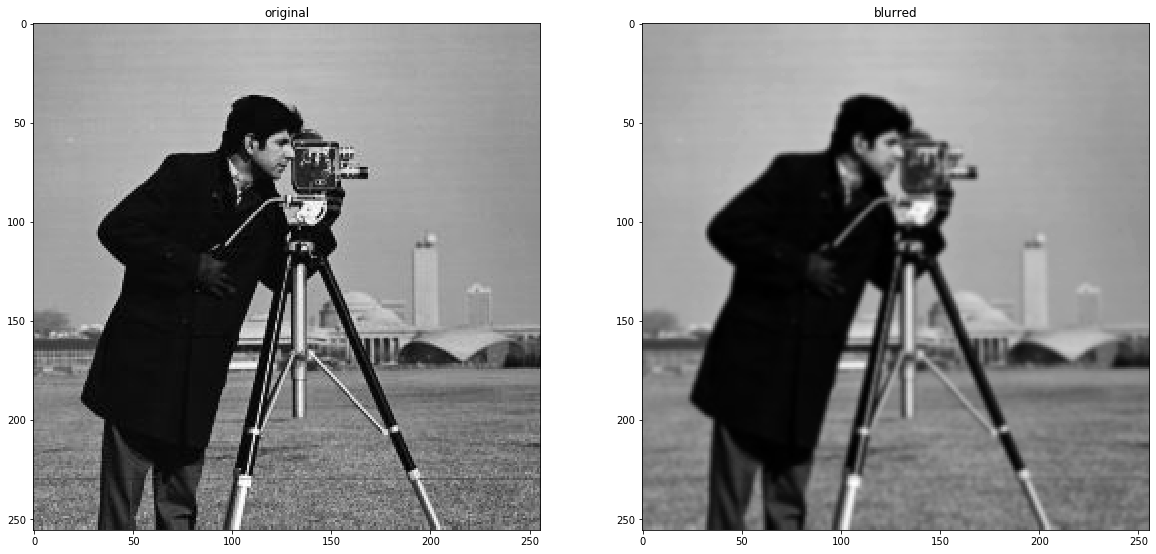

In [9]:
image = cv2.imread('images/cameraman.jpg', cv2.IMREAD_GRAYSCALE)
gaussian_noise = GaussianNoise()
image_blurred = gaussian_noise(image)

# plotting
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))
ax[0].set_title('original')
ax[1].set_title('blurred')
ax[0].imshow(image, cmap='gray')
ax[1].imshow(image_blurred, cmap='gray')

### 1.B Gradient Intensity

In [10]:
class GradientIntensity:
    """
    We use Sobel filters to convolve over image (numpy ndarray) to calculate gradient intensity on both
    horizontal and vertical directions. Finally returns magnitude G and slope theta as follows:

    G = sqrt(Ix^2 + Iy^2)

    theta = arctan(Ix/Iy)

    We use these Sobel filters as default:

    Kx =
    [[-1 0 1],
    [-2 0 2],
    [-1 0 1]]

    Ky =
    [[1 2 1],
    [0 0 0],
    [-1 -2 -1]]

    """

    def __init__(self, hf=None, vf=None, init=True):
        """
        Initialize filters

        :param hf: Horizontal filter matrix -> numpy ndarray
        :param vf: Vertical filter matrix -> numpy ndarray
        :param init: whether initialize Sobel filters or initialize using user provided input -> default Sobel
        """

        if not init:
            self.hf = hf
            self.vf = vf
        else:
            self.hf = np.array(
                [[-1, 0, 1],
                 [-2, 0, 2],
                 [-1, 0, 1]])

            self.vf = np.array(
                [[1, 2, 1],
                 [0, 0, 0],
                 [-1, -2, -1]])

    def __call__(self, x):
        if not str(type(x)).__contains__('numpy'):
            raise ValueError('Invalid input. Please provide numpy ndarray image.')
        Ix = ndimage.filters.convolve(x, self.hf)
        Iy = ndimage.filters.convolve(x, self.vf)

        G = np.sqrt(np.power(Ix, 2)  + np.power(Iy, 2))
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)

        return G, theta

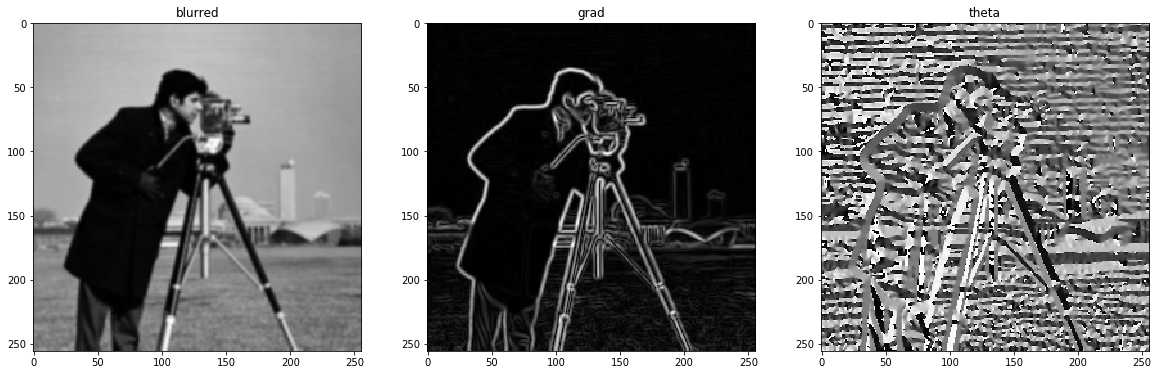

In [11]:
to_grayscale = ToGrayscale()
image = np.array(to_grayscale(open_image('images/cameraman.jpg')), dtype=float)  # this 'float' took me 7 hours!
gaussian_noise = GaussianNoise()
image_blurred = gaussian_noise(image)
gradient_intensity = GradientIntensity()
image_grad, image_theta = gradient_intensity(image_blurred)

# plotting
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 15))
ax[0].set_title('blurred')
ax[1].set_title('grad')
ax[2].set_title('theta')
ax[0].imshow(image_blurred, cmap='gray')
ax[1].imshow(image_grad, cmap='gray')
ax[2].imshow(image_theta, cmap='gray')

### 1.C Non-Max Suppression

In [14]:
class NonMaxSuppression:
    """
    Get gradient of image w.r.t the filters and degree of gradients (theta) and keep
    most intensified pixel in each direction.
    Note: d_prime = d-180
    """

    def __init__(self):
        pass

    def __call__(self, grad_img, grad_dir):
        """
        Get non-max suppressed image by preserving most intensified pixels

        :param grad_img: Gradient image gathered by convolving filters on original image -> numpy ndarray
        :param grad_dir: Gradient directions gathered by convolving filters on original image -> numpy ndarray
        :return: Soft-edge numpy ndarray image
        """

        z = np.zeros(shape=grad_img.shape, dtype=np.int32)

        for h in range(grad_img.shape[0]):
            for v in range(grad_img.shape[1]):
                degree = self.__angle__(grad_dir[h][v])

                try:
                    if degree == 0:
                        if grad_img[h][v] >= grad_img[h][v - 1] and grad_img[h][v] >= grad_img[h][v + 1]:
                            z[h][v] = grad_img[h][v]
                    elif degree == 45:
                        if grad_img[h][v] >= grad_img[h - 1][v + 1] and grad_img[h][v] >= grad_img[h + 1][v - 1]:
                            z[h][v] = grad_img[h][v]
                    elif degree == 90:
                        if grad_img[h][v] >= grad_img[h - 1][v] and grad_img[h][v] >= grad_img[h + 1][v]:
                            z[h][v] = grad_img[h][v]
                    elif degree == 135:
                        if grad_img[h][v] >= grad_img[h - 1][v - 1] and grad_img[h][v] >= grad_img[h + 1][v + 1]:
                            z[h][v] = grad_img[h][v]
                except IndexError as exc:
                    # Handle boundary index errors
                    pass
        return z

    @staticmethod
    def __angle__(a):
        """
        Convert gradient directions in radian to 4 possible direction in degree system

        :param a: Radian value of gradient direction numpy ndarray matrix
        :return: A int within {0, 45, 90, 135}
        """
        angle = np.rad2deg(a) % 180
        if (0 <= angle < 22.5) or (157.5 <= angle < 180):
            angle = 0
        elif 22.5 <= angle < 67.5:
            angle = 45
        elif 67.5 <= angle < 112.5:
            angle = 90
        elif 112.5 <= angle < 157.5:
            angle = 135
        return angle

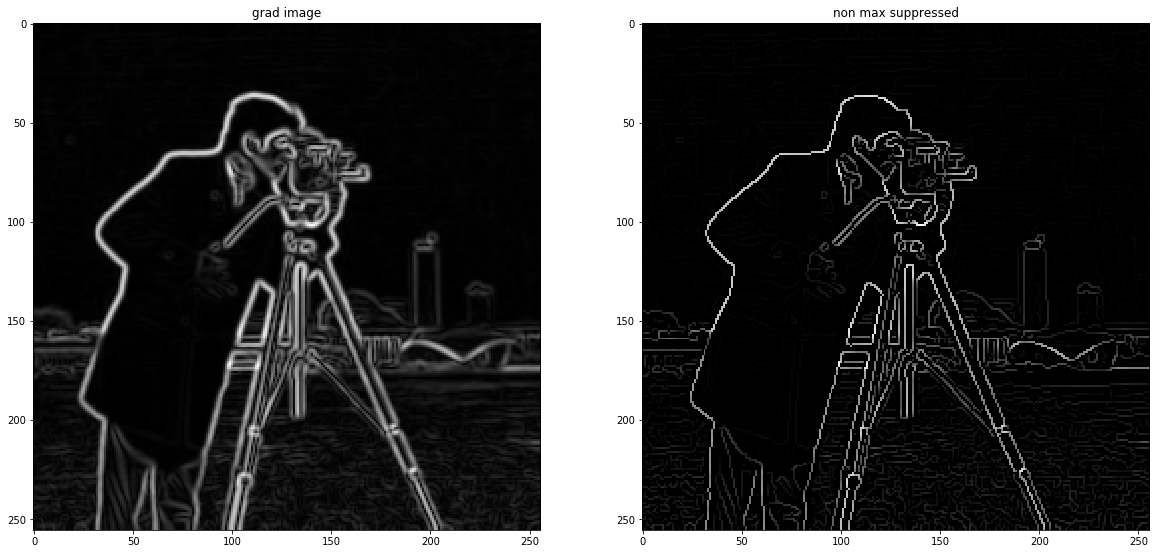

In [21]:
non_max_suppression = NonMaxSuppression()
image_non_max = non_max_suppression(image_grad, image_theta)

# plotting
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))
ax[0].imshow(image_grad, cmap='gray')
ax[1].imshow(image_non_max, cmap='gray')
ax[0].set_title('grad image')
ax[1].set_title('non max suppressed')
plt.show()



### 1.D Thresholding

In [24]:
class Thresholding:
    def __init__(self, high_threshold = 90, low_threshold = 30):
        self.high_threshold = high_threshold
        self.low_threshold = low_threshold
        self.weak = 29
        self.strong = 255
        self.flag = self.weak*9

    def _threshold_image(self, image):
        thresholded = np.empty(image.shape)
        thresholded[np.where(image>self.high_threshold)] = self.strong
        thresholded[np.where(((image>self.low_threshold) & (image<=self.high_threshold)))] = self.weak
        return thresholded

    def __call__(self, image):
        thresholded = self._threshold_image(image)
        for i in range(thresholded.shape[0]):
            for j in range(thresholded.shape[1]):
                if thresholded[i, j] == self.weak:
                    if np.sum(thresholded[i-1:i+2, j-1:j+2]) > self.flag:
                        thresholded[i ,j] = self.strong
                    else:
                        thresholded[i ,j] = 0
        return thresholded


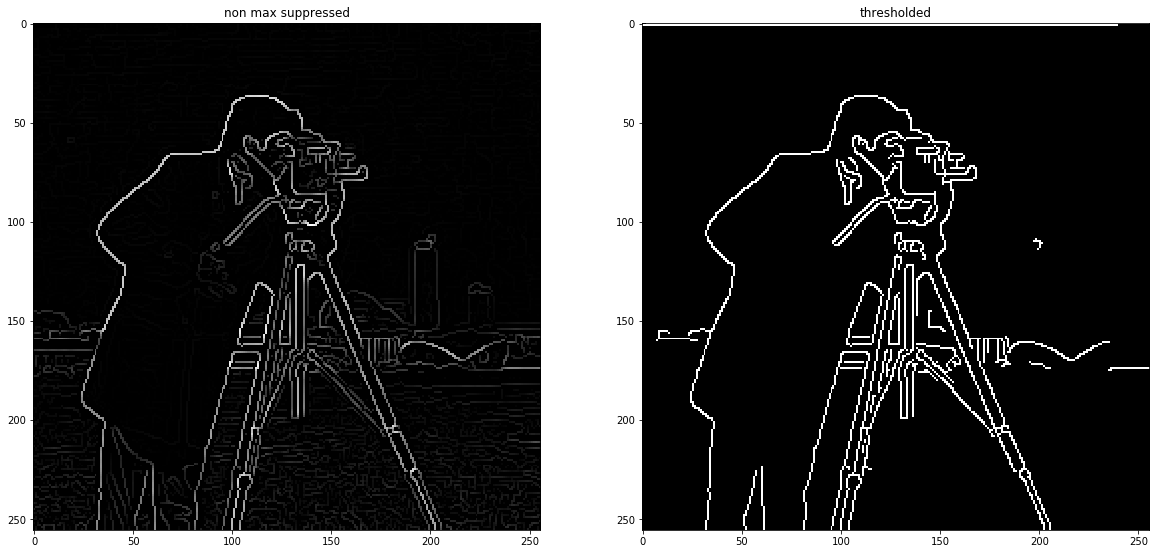

In [32]:
thresholding = Thresholding()
thresholded = thresholding(image_non_max)

# plotting
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))
ax[0].imshow(image_non_max, cmap='gray')
ax[1].imshow(thresholded, cmap='gray')
ax[0].set_title('non max suppressed')
ax[1].set_title('thresholded')

plt.show()

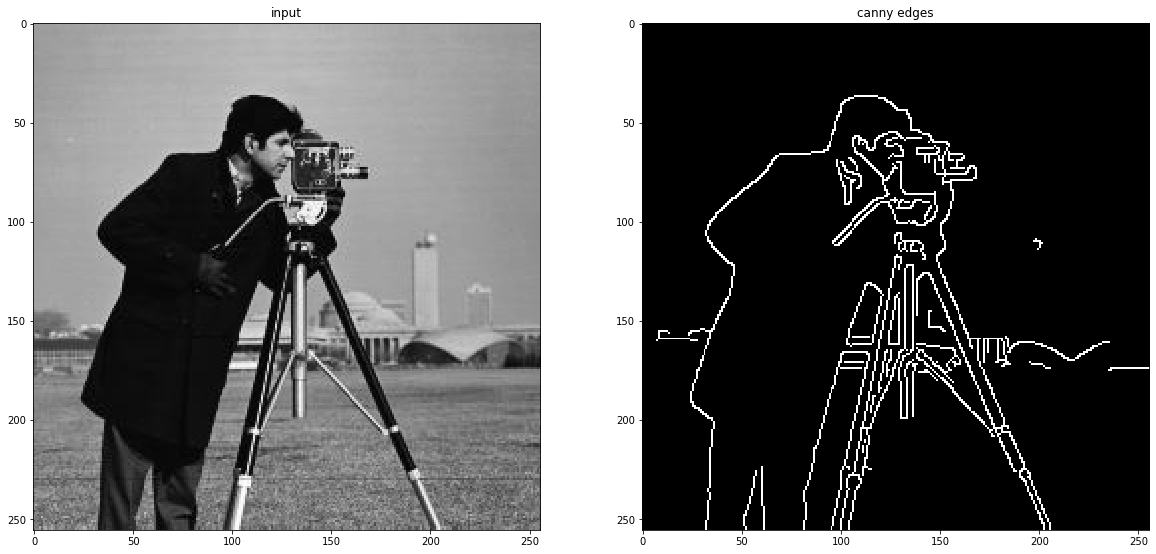

In [26]:
image = cv2.imread('images/cameraman.jpg', 0).astype(float)
t1 = time.time()
image_blurred = GaussianNoise()(image)
image_grad, image_theta = GradientIntensity()(image_blurred)
image_suppressed = NonMaxSuppression()(image_grad, image_theta)
image_final = Thresholding()(image_suppressed)
t1 = time.time()-t1

# plotting
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))
ax[0].imshow(image, cmap='gray')
ax[1].imshow(image_final, cmap='gray')
ax[0].set_title('input')
ax[1].set_title('canny edges')

plt.show()